### Step 1: Import Datasets and merge

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load macroeconomic and forex datasets
macro = pd.read_csv("macro_data.csv", parse_dates=["DATE"]).set_index("DATE")
forex = pd.read_csv("forex_merged_cleaned.csv", parse_dates=["DATE"]).set_index("DATE")

In [21]:
print("Macro Data:")
print(macro.head(25))

print("\nForex Data:")
print(forex.head(25))

Macro Data:
              Trade Balance  Inflation (CPI)  Core Inflation  Interest Rate  \
DATE                                                                          
2002-01-01 -29678.000000000    177.700000000   188.700000000    1.730000000   
2002-02-01 -32501.000000000    178.000000000   189.100000000    1.740000000   
2002-03-01 -31161.000000000    178.500000000   189.200000000    1.730000000   
2002-04-01 -33965.000000000    179.300000000   189.700000000    1.750000000   
2002-05-01 -34026.000000000    179.500000000   190.000000000    1.750000000   
2002-06-01 -34732.000000000    179.600000000   190.200000000    1.750000000   
2002-07-01 -33913.000000000    180.000000000   190.500000000    1.730000000   
2002-08-01 -36385.000000000    180.500000000   191.100000000    1.740000000   
2002-09-01 -36088.000000000    180.800000000   191.300000000    1.750000000   
2002-10-01 -35095.000000000    181.200000000   191.500000000    1.750000000   
2002-11-01 -39515.000000000    181.50000

In [22]:
# Convert exchange rates to log returns
log_returns = np.log(forex / forex.shift(1))
log_returns = log_returns.dropna()
log_returns.columns = [col + " Return" for col in log_returns.columns]

In [68]:
# Align and merge macro with log returns on DATE

LAG_PERIODS   = (1, 2, 3, 4,5,12,24,60)          
ROLL_WINDOWS  = (3, 5, 7,10)             


def enrich_macro_safe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create lag & rolling features with NO look-ahead bias.
    All features at time t use data ≤ t-1.
    """
    fea = df.copy()                        # t-level original values

    # 1) Lags (t-p)
    for p in LAG_PERIODS:
        fea = pd.concat([fea,
                         df.shift(p).add_suffix(f"_lag{p}")],
                        axis=1)

    # 2) Rolling statistics over past window (up to t-1)
    for w in ROLL_WINDOWS:
        roll_mean = (
            df.rolling(w).mean()   # mean of [t-w+1 … t]
              .shift(1)            # now window is [t-w … t-1]
              .add_suffix(f"_rollmean{w}")
        )
        roll_std  = (
            df.rolling(w).std()
              .shift(1)
              .add_suffix(f"_rollstd{w}")
        )
        fea = pd.concat([fea, roll_mean, roll_std], axis=1)

    # memory-friendly & drop rows that have NaNs due to shifting
    return fea.astype("float32").dropna()

macro_fea = enrich_macro_safe(macro)                       # ← engineered features
full_df   = pd.merge(macro_fea, log_returns,
                     left_index=True, right_index=True,
                     how="inner").dropna()

# Drop rows with any missing data (can customize later)
full_df = full_df.dropna()
full_df.head()

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,...,USD-AUD Return,USD-CAD Return,USD-CHF Return,USD-CNY Return,USD-EUR Return,USD-GBP Return,USD-HKD Return,USD-JPY Return,USD-NZD Return,USD-XAU Return
DATE,,,,,,,,,,,,,,,,,,,,,
2007-02-01,-58479.000000000,204.225997925,209.134994507,5.260000229,100.716598511,364006.000000000,91.300003052,4.500000000,50.400001526,1438.239990234,...,0.014820764,0.009562098,0.019479554,-0.003954249,0.012581660,-0.003414625,0.003849613,0.013680560,0.018207083,-0.027734767
2007-03-01,-62183.000000000,205.287994385,209.417999268,5.260000229,100.895202637,367158.000000000,88.400001526,4.400000095,54.099998474,1406.819946289,...,-0.014059536,-0.005965588,-0.019889441,-0.004124940,-0.015003518,0.000814374,0.000665762,-0.017888967,-0.014649120,-0.025837807
2007-04-01,-60494.000000000,205.904006958,209.746994019,5.250000000,101.572303772,366187.000000000,87.099998474,4.500000000,52.799999237,1420.859985352,...,-0.025933179,-0.013684107,-0.003367421,-0.001318409,-0.009404576,-0.001983875,0.000076790,-0.006176254,-0.018364692,0.011344800
2007-05-01,-59572.000000000,206.755004883,210.057998657,5.250000000,101.626899719,370934.000000000,88.300003052,4.400000095,52.700000763,1482.369995117,...,-0.026241818,-0.039144460,-0.006769053,-0.003654084,-0.021777025,-0.015980982,0.001138362,0.014324478,-0.035882604,-0.022141126
2007-06-01,-59997.000000000,207.233993530,210.391998291,5.250000000,101.654701233,368154.000000000,85.300003052,4.599999905,53.099998474,1530.619995117,...,0.002653801,-0.037459626,0.014799251,-0.007466173,0.014390861,0.009901320,-0.001880914,0.018238092,0.005009149,0.026775361


### Step 2: Run OLS Regression per Currency

In [69]:
import statsmodels.api as sm

# 1. Identify columns
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# 2. Store results
results = []

# 3. Loop through each currency return and run OLS
for target in fx_targets:
    X = full_df[macro_vars]
    y = full_df[target]
    
    # Add intercept
    X_const = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X_const).fit()
    
    # Store results
    results.append({
        "Currency": target.replace(" Return", ""),
        "R_squared": model.rsquared,
        "Adj_R_squared": model.rsquared_adj,
        "Coefficients": model.params.to_dict(),
        "P_values": model.pvalues.to_dict()
    })

In [70]:
# Flatten into a readable summary table
summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in results],
    "R_squared": [res["R_squared"] for res in results],
    "Adj_R_squared": [res["Adj_R_squared"] for res in results]
})

summary.sort_values("R_squared", ascending=False, inplace=True)
summary.head(10)

,Currency,R_squared,Adj_R_squared
0,USD-AUD,0.258531626,0.218745518
1,USD-CAD,0.244302365,0.203752735
8,USD-NZD,0.217360566,0.175365279
5,USD-GBP,0.159755163,0.114668855
4,USD-EUR,0.124699992,0.077732675
7,USD-JPY,0.104298279,0.056236235
3,USD-CNY,0.103325187,0.055210929
2,USD-CHF,0.083552586,0.034377359
9,USD-XAU,0.069483858,0.019553724
6,USD-HKD,0.053267815,0.002467552


In [71]:
# Create a DataFrame with currencies as rows and macro variables as columns
coeff_matrix = pd.DataFrame()

# Loop through results and pull each currency's coefficients
for res in results:
    currency = res["Currency"]
    coeffs = res["Coefficients"]
    
    # Convert to Series and name it with the currency
    coeff_series = pd.Series(coeffs, name=currency)
    
    # Append as a new row to the matrix
    coeff_matrix = pd.concat([coeff_matrix, coeff_series.to_frame().T], axis=0)

# Set currency names as the index
coeff_matrix.index.name = "Currency"

# Drop the constant (intercept) column if you only want macro variable effects
coeff_matrix = coeff_matrix.drop(columns="const", errors='ignore')

pd.set_option('display.float_format', '{:.9f}'.format)
coeff_matrix.head(10)

,Trade Balance,Inflation (CPI),Core Inflation,Interest Rate,Industrial Production,Retail Sales,Consumer Sentiment,Unemployment Rate,Manufacturing PMI,S&P 500 Index,VIX Index
Currency,,,,,,,,,,,
USD-AUD,-0.000000066,0.007427035,-0.006128466,-0.000592360,0.000976226,-0.000000288,0.001784992,-0.002946155,0.000441263,0.000002498,0.003182949
USD-CAD,-0.000000183,0.002991707,-0.001660344,-0.001818739,0.002291232,-0.000000313,0.000670222,-0.000465399,0.000095899,-0.000003124,0.001937800
USD-CHF,-0.000000220,0.003862743,-0.003612672,-0.000727786,-0.000623662,0.000000037,0.001198314,-0.000914718,0.000069904,-0.000003614,0.001357666
USD-CNY,-0.000000039,0.000714928,-0.000418831,-0.000425064,-0.000138426,0.000000032,0.000278623,-0.000621958,-0.000022509,-0.000007991,0.000328555
USD-EUR,0.000000002,0.004028923,-0.003508384,-0.000964376,0.000033621,-0.000000118,0.000883058,-0.001613894,0.000468879,0.000003667,0.001651943
USD-GBP,-0.000000461,0.002140739,-0.001332757,-0.002076201,0.000086896,-0.000000150,0.000604168,-0.003315394,-0.000048323,-0.000008923,0.001416011
USD-HKD,-0.000000023,-0.000039548,0.000016994,-0.000097083,-0.000059534,0.000000013,0.000004839,-0.000121398,0.000022374,-0.000000852,-0.000016195
USD-JPY,-0.000000251,0.003157865,-0.003500432,-0.002262105,-0.000913028,0.000000276,0.000831919,0.001442401,-0.000573726,-0.000008125,-0.000262253
USD-NZD,-0.000000018,0.005775317,-0.004886043,-0.000338180,0.001247991,-0.000000191,0.001390696,-0.002839134,0.000392226,0.000001786,0.003142000


### STEP 3: Train a Predictive Model (Lasso)

In [72]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Define train/test split
train_end = "2022-12-31"

# Training set: data until end of 2022
train_df = full_df.loc[:train_end]

# Test set: data from 2023 onward
test_df = full_df.loc["2023-01-01":]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (191, 197)
Test shape: (26, 197)


In [74]:
# Macro variables (predictors) and currency returns (targets)
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

# Define X and Y for train and test
X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [75]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

lasso_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    lasso = Lasso(alpha=0.001, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    lasso_results.append({
        "Currency": target.replace(" Return", ""),
        "RMSE": rmse,
        "MAE": mae,
        "Model": lasso,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [76]:
# Create a summary DataFrame
lasso_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in lasso_results],
    "RMSE": [res["RMSE"] for res in lasso_results],
    "MAE": [res["MAE"] for res in lasso_results]
})

# Sort by RMSE (lower = better)
lasso_summary = lasso_summary.sort_values("RMSE")
print(lasso_summary.head(10))

  Currency        RMSE         MAE
6  USD-HKD 0.002197578 0.001644922
3  USD-CNY 0.016929955 0.013076097
5  USD-GBP 0.028060712 0.023916580
1  USD-CAD 0.029875797 0.026285657
2  USD-CHF 0.033917748 0.028902039
4  USD-EUR 0.034113342 0.029490612
7  USD-JPY 0.035382322 0.027990289
9  USD-XAU 0.038221523 0.031802178
0  USD-AUD 0.047086157 0.041016580
8  USD-NZD 0.058748431 0.050728316


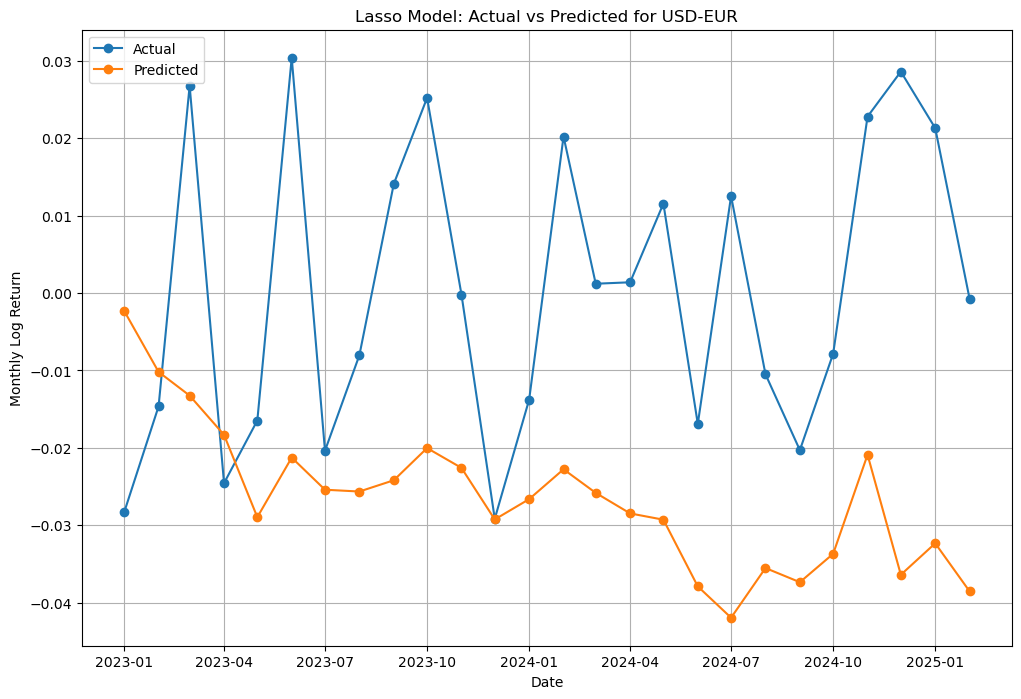

In [77]:
# Example: Plot for one currency (e.g., USD-EUR)
currency_to_plot = "USD-EUR"

for res in lasso_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"Lasso Model: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break

### STEP 4: Train a Predictive Model (XGBoost)

In [78]:
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [79]:
# Inputs and outputs
macro_vars = macro.columns.tolist()
fx_targets = [col for col in full_df.columns if "Return" in col]

X_train = train_df[macro_vars]
X_test = test_df[macro_vars]

In [80]:
xgb_results = []

for target in fx_targets:
    y_train = train_df[target]
    y_test = test_df[target]
    
    # Initialize XGBoost model
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    
    # Fit the model
    xgb.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = xgb.predict(X_test)
    
    # Evaluate
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    xgb_results.append({
        "Currency": target.replace(" Return", ""),
        "RMSE": rmse,
        "MAE": mae,
        "Model": xgb,
        "y_test": y_test,
        "y_pred": y_pred
    })

In [81]:
# Create summary table
xgb_summary = pd.DataFrame({
    "Currency": [res["Currency"] for res in xgb_results],
    "RMSE": [res["RMSE"] for res in xgb_results],
    "MAE": [res["MAE"] for res in xgb_results]
})

xgb_summary = xgb_summary.sort_values("RMSE")
print(xgb_summary.head(10))

  Currency        RMSE         MAE
6  USD-HKD 0.003303432 0.002656733
3  USD-CNY 0.016540545 0.013620467
1  USD-CAD 0.017034136 0.014785572
4  USD-EUR 0.019648674 0.016534762
2  USD-CHF 0.027490506 0.023442995
5  USD-GBP 0.029987127 0.024568984
0  USD-AUD 0.030069116 0.024308234
9  USD-XAU 0.040626037 0.030999143
7  USD-JPY 0.042670967 0.034284894
8  USD-NZD 0.050330302 0.044162914


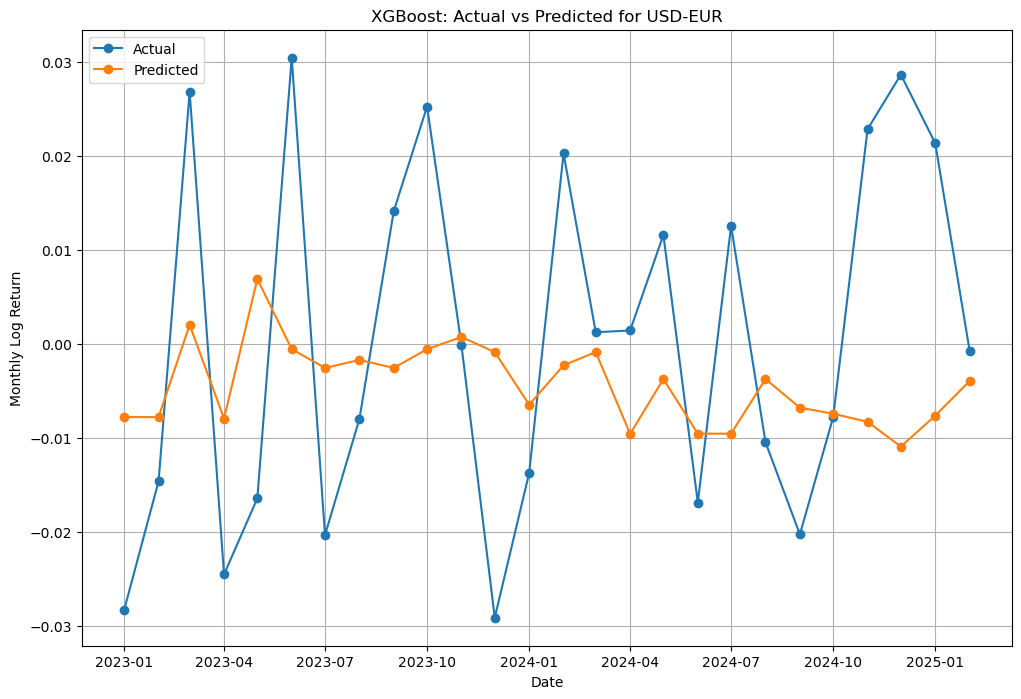

In [82]:
import matplotlib.pyplot as plt

currency_to_plot = "USD-EUR"

for res in xgb_results:
    if res["Currency"] == currency_to_plot:
        plt.figure(figsize=(12,8))
        plt.plot(res["y_test"].index, res["y_test"], label="Actual", marker='o')
        plt.plot(res["y_test"].index, res["y_pred"], label="Predicted", marker='o')
        plt.title(f"XGBoost: Actual vs Predicted for {currency_to_plot}")
        plt.xlabel("Date")
        plt.ylabel("Monthly Log Return")
        plt.legend()
        plt.grid(True)
        plt.show()
        break